In [313]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as sco
from datetime import datetime
import streamlit as st

In [314]:
tickers = ['META', 'MSFT', 'GOOGL', 'AAPL']
start_date = '2021-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Model Parameters
trading_days = 252
risk_free_rate = 0.04
num_portfolios = 25000

In [315]:
data = yf.download(tickers, start=start_date, end=end_date)['Close']

log_returns = np.log(data / data.shift(1)).dropna()
mean_returns_annual = log_returns.mean() * 252
cov_matrix_annual = log_returns.cov() * 252

[*********************100%***********************]  4 of 4 completed


In [316]:
portfolio_returns = []
portfolio_volatility = []
portfolio_weights = []
sharpe_ratios = []

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    portfolio_weights.append(weights)

    returns = np.dot(weights, mean_returns_annual)
    portfolio_returns.append(returns)

    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annual, weights)))
    portfolio_volatility.append(volatility)

    sharpe = (returns - risk_free_rate) / volatility
    sharpe_ratios.append(sharpe)

results_data = {'Return': portfolio_returns, 'Volatility': portfolio_volatility, 'Sharpe Ratio': sharpe_ratios}
results_df = pd.DataFrame(results_data)

max_sharpe_portfolio = results_df.iloc[results_df['Sharpe Ratio'].idxmax()]
max_sharpe_weights = portfolio_weights[results_df['Sharpe Ratio'].idxmax()]

min_vol_portfolio = results_df.iloc[results_df['Volatility'].idxmin()]
min_vol_weights = portfolio_weights[results_df['Volatility'].idxmin()]

In [317]:
def portfolio_volatility_func(weights, mean_returns, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_return_func(weights, mean_returns, cov_matrix):
    return np.dot(weights, mean_returns)

In [318]:
frontier_volatility_list = []

target_returns = np.linspace(min(mean_returns_annual), max(mean_returns_annual), 100)
num_assets = len(tickers)

args = (mean_returns_annual, cov_matrix_annual)

bounds = tuple((0, 1) for asset in range(num_assets))

initial_guess = num_assets * [1 / num_assets]

In [319]:

for target_return in target_returns:
    # Boundaries for optimizer
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: portfolio_return_func(x, mean_returns_annual, cov_matrix_annual) - target_return}
    )

    result = sco.minimize(
        fun=portfolio_volatility_func,
        x0=initial_guess,
        args=args,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    frontier_volatility_list.append(result['fun'])

In [320]:
print("\n" + "-"*50)
print("Maximum Sharpe Ratio Portfolio")
print("-"*50)
print(f"Expected annual return: {max_sharpe_portfolio['Return']:.2%}")
print(f"Annual volatility (risk): {max_sharpe_portfolio['Volatility']:.2%}")
print(f"Sharpe Ratio: {max_sharpe_portfolio['Sharpe Ratio']:.2f}")
print("Portfolio weights:")
for i, ticker in enumerate(tickers):
    print(f"  {ticker}: {max_sharpe_weights[i]:.2%}")

print("\n" + "-"*50)
print("Minimum Variance Portfolio")
print("-"*50)
print(f"Expected annual return: {min_vol_portfolio['Return']:.2%}")
print(f"Annual volatility (risk): {min_vol_portfolio['Volatility']:.2%}")
print(f"Sharpe Ratio: {min_vol_portfolio['Sharpe Ratio']:.2f}")
print("Portfolio weights:")
for i, ticker in enumerate(tickers):
    print(f"  {ticker}: {min_vol_weights[i]:.2%}")
print("\n" + "-"*50)


--------------------------------------------------
Maximum Sharpe Ratio Portfolio
--------------------------------------------------
Expected annual return: 20.60%
Annual volatility (risk): 25.98%
Sharpe Ratio: 0.64
Portfolio weights:
  META: 0.82%
  MSFT: 47.92%
  GOOGL: 1.28%
  AAPL: 49.99%

--------------------------------------------------
Minimum Variance Portfolio
--------------------------------------------------
Expected annual return: 17.99%
Annual volatility (risk): 24.22%
Sharpe Ratio: 0.58
Portfolio weights:
  META: 29.90%
  MSFT: 13.70%
  GOOGL: 0.11%
  AAPL: 56.29%

--------------------------------------------------


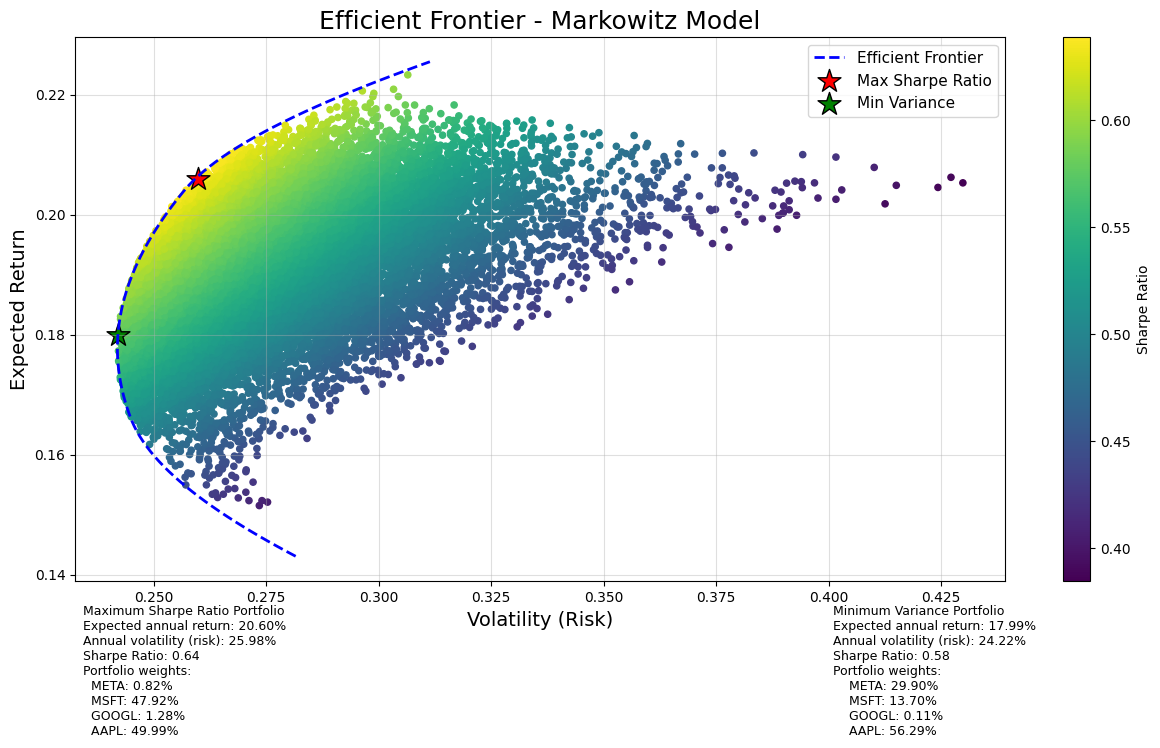

In [321]:
plt.figure(figsize=(15, 8))

# Scatter plot of all simulated portfolios
scatter = plt.scatter(
    results_df['Volatility'],
    results_df['Return'],
    c=results_df['Sharpe Ratio'],
    cmap='viridis',
    marker='o',
    s=20
)

# Plotting the efficient frontier line
plt.plot(
    frontier_volatility_list,
    target_returns,
    'b--', # Blue dashed line
    linewidth=2,
    label='Efficient Frontier'
)

# Marking the maximum Sharpe Ratio portfolio (red star)
plt.scatter(
    max_sharpe_portfolio['Volatility'],
    max_sharpe_portfolio['Return'],
    marker='*',
    color='red',
    s=300,
    label='Max Sharpe Ratio',
    edgecolors='black'
)

# Marking the minimum variance portfolio (green star)
plt.scatter(
    min_vol_portfolio['Volatility'],
    min_vol_portfolio['Return'],
    marker='*',
    color='green',
    s=300,
    label='Min Variance',
    edgecolors='black'
)

# Adding title and axis labels
plt.title('Efficient Frontier - Markowitz Model', fontsize=18)
plt.xlabel('Volatility (Risk)', fontsize=14)
plt.ylabel('Expected Return', fontsize=14)

# Adding colorbar and legend
plt.colorbar(scatter, label="Sharpe Ratio")
plt.legend(loc='best', fontsize=11)

# Show plot
plt.grid(
    True,
    alpha=0.4
)


text_sharpe = (
    "Maximum Sharpe Ratio Portfolio\n"
    f"Expected annual return: {max_sharpe_portfolio['Return']:.2%}\n"+
    f"Annual volatility (risk): {max_sharpe_portfolio['Volatility']:.2%}\n"+
    f"Sharpe Ratio: {max_sharpe_portfolio['Sharpe Ratio']:.2f}\n"+
    "Portfolio weights:"  
)

weights_sharpe = [
    f"\n  {ticker}: {max_sharpe_weights[i]:.2%}"
    for i, ticker in enumerate(tickers)
]

text_results_sharpe = text_sharpe + "".join(weights_sharpe)

plt.figtext(0.13, 0.01, text_results_sharpe, wrap=True, horizontalalignment='left', fontsize=9, color='black')


text_vol = (
    "Minimum Variance Portfolio\n" +
    f"Expected annual return: {min_vol_portfolio['Return']:.2%}\n" +
    f"Annual volatility (risk): {min_vol_portfolio['Volatility']:.2%}\n" +
    f"Sharpe Ratio: {min_vol_portfolio['Sharpe Ratio']:.2f}\n" +
    "Portfolio weights:"
)

weights_vol = [
    f"\n    {ticker}: {min_vol_weights[i]:.2%}"
    for i, ticker in enumerate(tickers)
]

text_results_vol = text_vol +''.join(weights_vol)

plt.figtext(0.63, 0.01, text_results_vol, wrap = True, horizontalalignment='left', fontsize=9, color='black')
plt.subplots_adjust(bottom=(len(tickers))/10/2) 

plt.show()